In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from Constants import *

In [2]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = BATCH_SIZE
)

Found 5712 files belonging to 4 classes.


In [3]:
test_dataset = keras.preprocessing.image_dataset_from_directory(
    VALIDATION_PATH,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = BATCH_SIZE
)

Found 1311 files belonging to 4 classes.


In [4]:
class_names = train_dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['glioma', 'meningioma', 'notumor', 'pituitary']
4


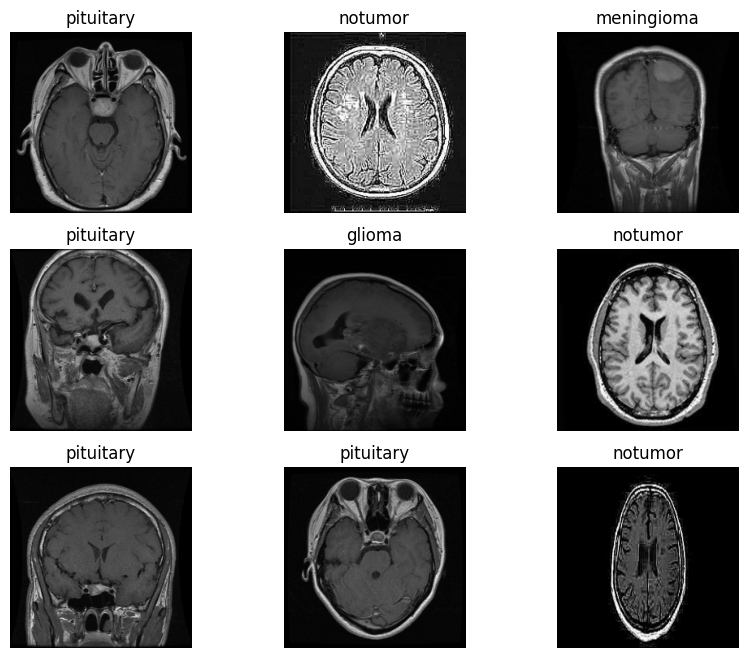

In [5]:
plt.figure(figsize = (10, 8))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
train_size = int(0.85 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = int(1 * len(test_dataset))

In [7]:
train_set = train_dataset.take(train_size)
val_set = train_dataset.skip(train_size)
test_set = test_dataset.take(test_size)

In [8]:
print(len(train_set),'\n',len(test_set),'\n',len(val_set))

303 
 82 
 54


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [11]:
resize_and_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [12]:
augmented_data = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape = (image_size, image_size,
                                     3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomFlip("horizontal_and_vertical")
])

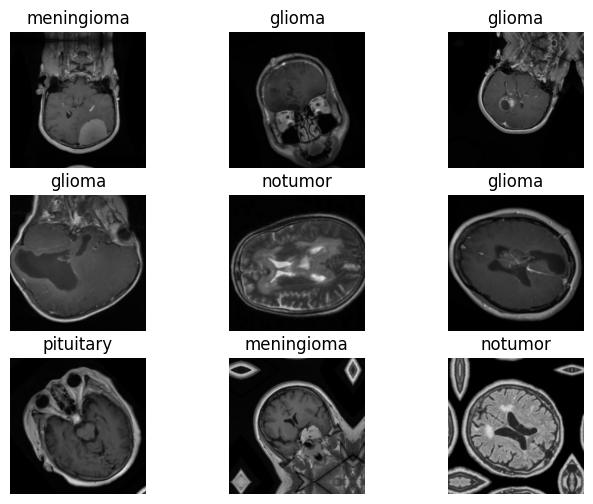

In [13]:
plt.figure(figsize = (8, 6))
for images, label in train_set.take(1):
    for i in range(9):
        augmented_images = augmented_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.title(class_names[label[i]])
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
input_shape = (BATCH_SIZE, image_size, image_size, 3)

model = keras.Sequential([
    resize_and_rescale,
    augmented_data,
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation = 'softmax'),    
])

model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (16, 222, 222, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (16, 111, 111, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (16, 111, 111, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (16, 109, 109, 32)        18464     
                                                      

In [16]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [17]:
history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    epochs = 20,
                    verbose = 1
                    )

Epoch 1/20
303/303 [==============================] - 440s 1s/step - loss: 1.1204 - accuracy: 0.4835 - val_loss: 0.8875 - val_accuracy: 0.6817
Epoch 2/20
303/303 [==============================] - 431s 1s/step - loss: 0.9188 - accuracy: 0.6203 - val_loss: 0.8967 - val_accuracy: 0.6412
Epoch 3/20
303/303 [==============================] - 418s 1s/step - loss: 0.8317 - accuracy: 0.6660 - val_loss: 0.9925 - val_accuracy: 0.5405
Epoch 4/20
303/303 [==============================] - 426s 1s/step - loss: 0.7816 - accuracy: 0.6953 - val_loss: 0.7592 - val_accuracy: 0.6887
Epoch 5/20
303/303 [==============================] - 421s 1s/step - loss: 0.7312 - accuracy: 0.7116 - val_loss: 0.7900 - val_accuracy: 0.6701
Epoch 6/20
303/303 [==============================] - 420s 1s/step - loss: 0.6851 - accuracy: 0.7351 - val_loss: 0.6762 - val_accuracy: 0.7477
Epoch 7/20
303/303 [==============================] - 419s 1s/step - loss: 0.6320 - accuracy: 0.7531 - val_loss: 0.5736 - val_accuracy: 0.7743

In [18]:
loss = model.evaluate(test_set)
loss

82/82 [==============================] - 22s 238ms/step - loss: 0.3953 - accuracy: 0.8635


[0.39531922340393066, 0.8634629845619202]

In [19]:
history = history.history

In [20]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

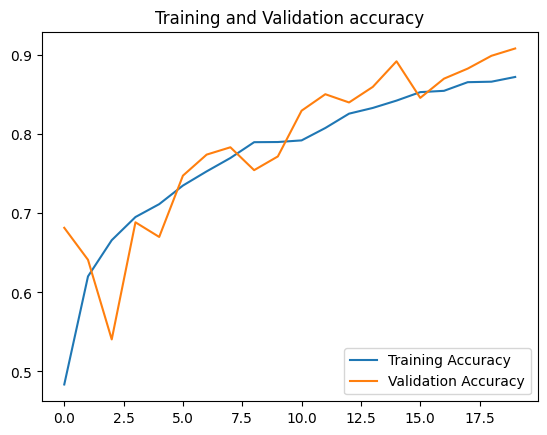

In [21]:
plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation accuracy")
plt.show()

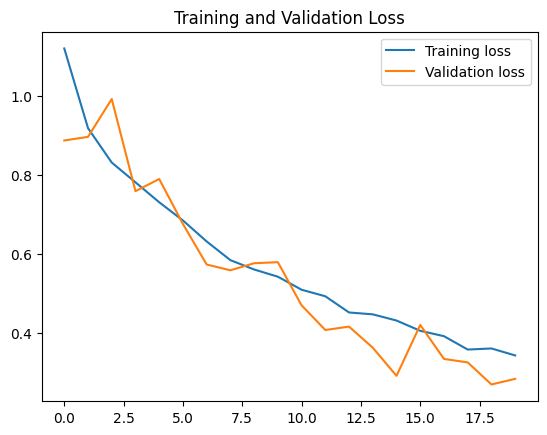

In [22]:
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [23]:
model_version = 1
model.save(f"../outputs/{model_version}")

# make changes to model architecture and save it by changing the model version number

INFO:tensorflow:Assets written to: ../outputs/1\assets


INFO:tensorflow:Assets written to: ../outputs/1\assets


In [24]:
#model = tf.keras.models.load_model("../outputs/1")

In [ ]:
for images_batch, labels_batch in test_set.take(1):
    displayed_image = images_batch[0].numpy().astype("uint8")
    image_label = labels_batch[0].numpy()
    
    print("Predicting on sample from test set...")
    plt.imshow(displayed_image)
    plt.axis("off")
    image_prediction = model.predict(images_batch)
    actual = class_names[np.argmax(image_prediction[0])]
    predicted = class_names[image_label]
    print("Predicted label: ", actual)
    print("Actual label:", predicted)

In [ ]:
for images_batch, labels_batch in test_set.take(10):
    displayed_image = images_batch[0].numpy().astype("uint8")
    image_label = labels_batch[0].numpy()
    
    #print("Predicting on sample from test set...")
    #plt.imshow(displayed_image)
    #plt.axis("off")
    image_prediction = model.predict(images_batch)
    actual = class_names[np.argmax(image_prediction[0])]
    predicted = class_names[image_label]
    print("Predicted label: ", actual)
    print("Actual label:", predicted)

In [43]:
if actual == predicted:
    print("Prediction matches!")
else:
    print("Wrong prediction!")

Wrong prediction!


In [39]:
def predict(model, img):
    image_array = keras.preprocessing.image.img_to_array(images[1].numpy())
    image_array = tf.expand_dims(image_array, 0)
    
    predictions = model.predict(image_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence  

1/1 [==============================] - 0s 41ms/step


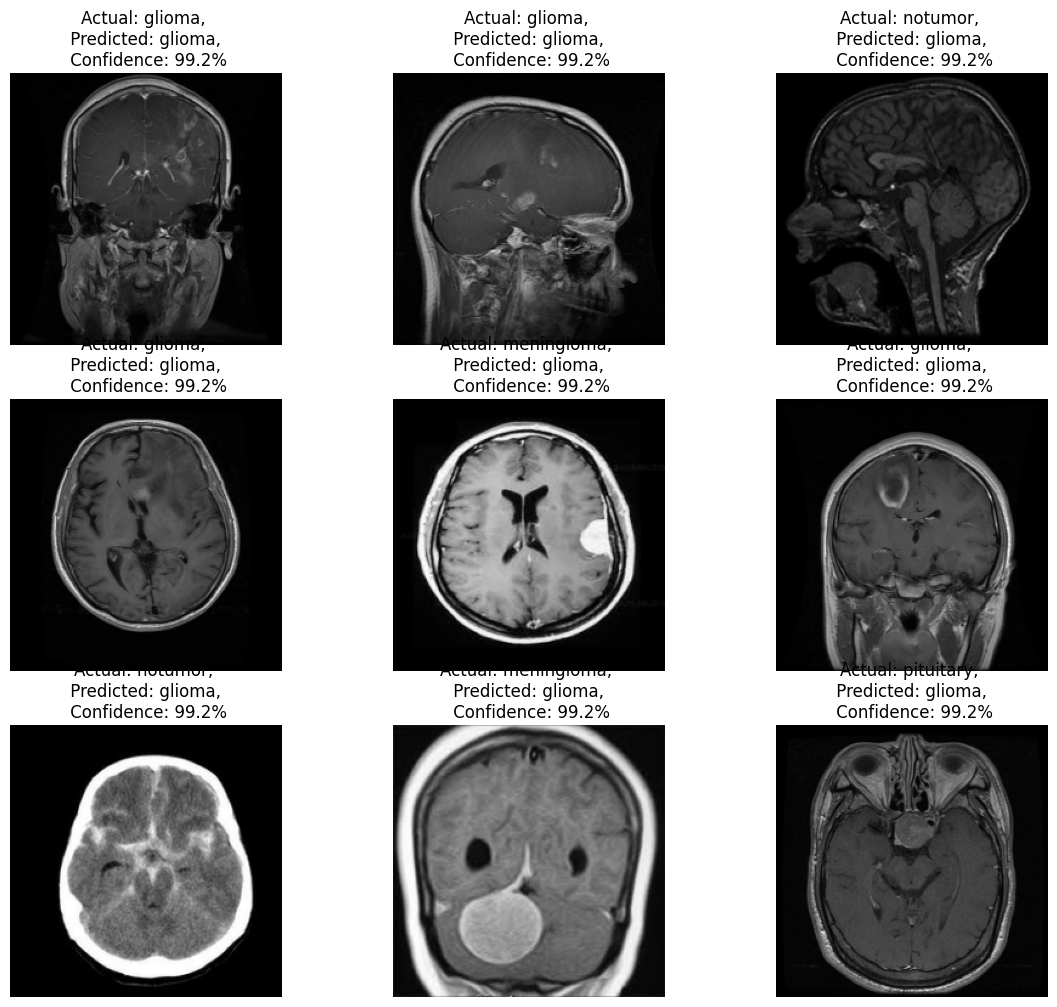

In [40]:
plt.figure(figsize = (14, 12))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        #plt.title("Actual class: {}, \n Predicted class: {}, \n Confidence: {}%", actual_class, predicted_class, confidence)
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [29]:
# this line saves the model just by running, uncomment when new model version is to be saved
#model_version = max([int(i) for i in os.listdir("../saved_models") + [0]]) + 1
#model.save(f"../outputs/{model_version}")

In [30]:
#model = tf.keras.models.load_model("../outputs/1")